In [11]:
"""
Learning to optimize parametric Quadratic Programming (pQP)
problems using Neuromancer.

Problem formulation pQP:
    minimize     x^2 + y^2
    subject to
               -x - y + p1 <= 0,
               x + y - p1 - 1 <= 0,
               x - y + p2 - 1 <= 0,
               -x + y - p2 <= 0
"""



'\nLearning to optimize parametric Quadratic Programming (pQP)\nproblems using Neuromancer.\n\nProblem formulation pQP:\n    minimize     x^2 + y^2\n    subject to\n               -x - y + p1 <= 0,\n               x + y - p1 - 1 <= 0,\n               x - y + p2 - 1 <= 0,\n               -x + y - p2 <= 0\n'

In [12]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node


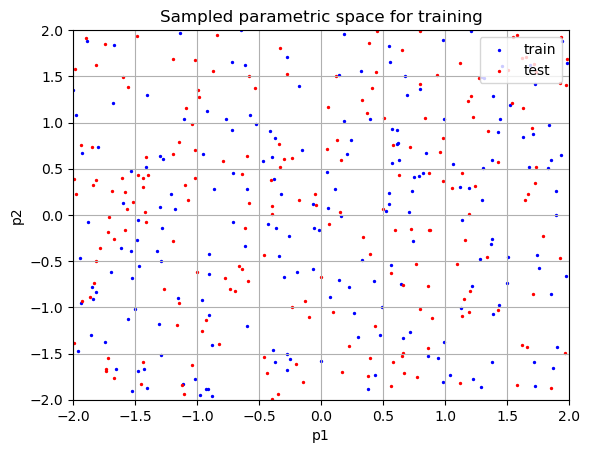

In [13]:

"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
nsim = 200  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = -2.0, 2.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                    "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=100, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)


In [14]:

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]
"""
# # #  mpQP objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')
# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]
# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
g2 = x + y - p1 - 1
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 1
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]
"""
# # #  pQP problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
nm_problem = Problem(components, loss)


In [15]:

"""
# # #  pQP problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(nm_problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    nm_problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=2,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()



epoch: 0  train_loss: 120.16297912597656
epoch: 1  train_loss: 113.94854736328125


In [16]:

'''
#######################################
#######################################

Add on a standard ADMM correction layer

#######################################
########################################
'''
import ADMM as am
from importlib import reload
reload(am)
'''
# DEFINE THE OBJECTIVE
'''
def f_obj(x,parms):
    return torch.pow( x[0] ,2) + torch.pow( x[1], 2)
'''
# DEFINE THE CONSTRAINTS
'''
def F_ineq(x,parms):
    c_1 = -x[0] - x[1] + parms[0]
    c_2 = x[0] + x[1] - parms[0] - 1 
    c_3 = x[0] - x[1] + parms[1] - 1 
    c_4 = -x[0] + x[1] - parms[1]
    return torch.stack((c_1,c_2,c_3,c_4))
num_steps = 40 # number of ADMM iterations to take
x_dim = 2 # dimension of primal variable
n_ineq = 4 #number of inequality constraints
parm_dim = 2 #number of problem parameters


solver = am.ADMMSolver(
    f_obj = f_obj, 
    F_ineq = F_ineq,
    x_dim = x_dim, 
    n_ineq = n_ineq, 
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    )


# REMAP THROUGH DR CORRECTION
sol_map = Node(func, ['xi'], ['x_predicted'], name='map')
ADMM_correction = Node(solver,['x_predicted','xi'],['x'])
components = [features, sol_map, ADMM_correction]

objectives = []
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)



In [17]:
solver.num_steps = 10

/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_96662/2115636673.py:57: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_96662/2115636673.py:59: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_96662/2115636673.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_96662/2115636673.py:63: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg4.collections,


primal solution x=[0.5], y=[-0.75]
parameter p=(-1.25, -1.25)
primal solution Neuromancer x1=0.5552245378494263, x2=-0.8167994618415833
primal solution x=[0.5], y=[-0.5]
parameter p=(-1.0, -1.0)
primal solution Neuromancer x1=0.530965268611908, x2=-0.5613593459129333
primal solution x=[0.25], y=[-0.25]
parameter p=(-0.5, -0.5)
primal solution Neuromancer x1=0.2716926038265228, x2=-0.2618599832057953
primal solution x=[0.125], y=[-0.125]
parameter p=(-0.25, -0.25)
primal solution Neuromancer x1=0.14122667908668518, x2=-0.11137084662914276
primal solution x=[0.], y=[0.]
parameter p=(0.0, 0.0)
primal solution Neuromancer x1=0.04602605104446411, x2=0.0033020004630088806
primal solution x=[0.125], y=[0.125]
parameter p=(0.25, 0.25)
primal solution Neuromancer x1=0.13451507687568665, x2=0.11179440468549728
primal solution x=[0.25], y=[0.25]
parameter p=(0.5, 0.5)
primal solution Neuromancer x1=0.26707136631011963, x2=0.2630981206893921
primal solution x=[0.5], y=[0.5]
parameter p=(1.0, 1.0)


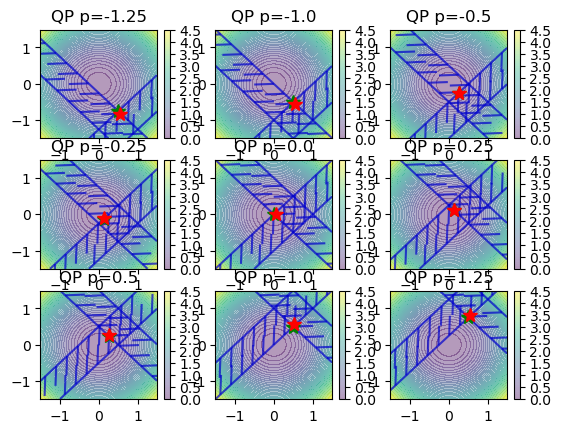

Solution for 200 problems via solver obtained in 1.2008 seconds
Solver mean constraints violation 0.0000
Solver mean objective value 0.6999

Neuromancer mean constraints violation no DR 1.0617
Neuromancer mean objective value no DR 0.0149
MSE primal optimizers no DR: 0.5599820264345348
mean objective value discrepancy np DR: 97.87 % 

Solution for 200 problems via Neuromancer obtained in 0.0168 seconds
Neuromancer mean constraints violation 0.0018
Neuromancer mean objective value 0.8433
Solution speedup factor 71.5463
MSE primal optimizers: 0.006939650110888017
mean objective value discrepancy: 20.49 %


In [18]:


'''
#######################################
#######################################

Compare to CVXPY Solver

#######################################
########################################
'''


"""
CVXPY benchmarks
"""
# Define the CVXPY problems.

def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                        [-x - y + p1 <= 0,
                        x + y - p1 - 1 <= 0,
                        x - y + p2 - 1 <= 0,
                        -x + y - p2 <= 0])
    return prob, x, y


"""
Plots
"""
# test problem parameters
params = [-1.25, -1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0, 1.25]
x1 = np.arange(-1.5, 1.5, 0.01)
y1 = np.arange(-1.5, 1.5, 0.01)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QP p={p}')

    c1 = xx + yy - p
    c2 = -xx - yy + p + 1
    c3 = -xx + yy - p + 1
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='mediumblue', alpha=0.7)
    plt.setp(cg1.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg2.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg3.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    plt.setp(cg4.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.7)

    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    
    prob, x, y = QP_param(p, p)
    
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                    'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'primal solution x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    #print(f' f: {model_out["test_" + f.key]}')
    #print(f' g1: {model_out["test_" + g1.key]}')
    #print(f' g2: {model_out["test_" + g2.key]}')

    #print(f' g3: {model_out["test_" + g3.key]}')
    #print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.show()
plt.show(block=True)
plt.interactive(False)

"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 1)
    con_3_viol = np.maximum(0, x - y + p2 - 1)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean
    #return [con_1_viol,con_2_viol,con_3_viol,con_4_viol]

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
with torch.no_grad():
    t = time.time()
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
    nm_time = time.time() - t

x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()


x_nm_noDR = model_out['test_x_predicted'][:, [0]].detach().numpy()
y_nm_noDR = model_out['test_x_predicted'][:, [1]].detach().numpy()


# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='ECOS_BB', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t

x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()


# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1_vec, p2_vec)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')




# Evaluate neuromancer solution no DR
nm_con_viol_mean = eval_constraints(x_nm_noDR, y_nm_noDR, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation no DR {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm_noDR, y_nm_noDR)
print(f'Neuromancer mean objective value no DR {nm_obj_mean:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm_noDR)[:,0]
dy = (y_solver - y_nm_noDR)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers no DR:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy np DR: {err_obj:.2f} % \n')



# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')


# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers0
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')




In [19]:
'''
Convergence Evaluation

WE solve from a given x 'prediction' as though from the initial solution map, as a means of comparison with other solution methodologies

'''


solver.num_steps = 30
p1 = -1.0
p2 = -1.0
test_p = torch.tensor([p1,p2],dtype=torch.float32)
test_x = torch.tensor([0.32,-0.37],dtype=torch.float32)

prob, x, y = QP_param(p1, p2)
prob.solve(solver='ECOS_BB', verbose=False)
prob.solve()
x_true = x.value
y_true = y.value


test_x = torch.unsqueeze(test_x,0)
test_p = torch.unsqueeze(test_p,0)

x_hist = solver(test_x,test_p)[3]
x_hist = torch.stack(x_hist).detach().numpy()
x_hist = x_hist[:,0,0:2]

#np.save('Convergence_Data/pqpADMM.npy',x_hist)

In [20]:
x_hist

array([[ 0.32      , -0.37      ],
       [ 0.3261538 , -0.5069231 ],
       [ 0.30166978, -0.4545912 ],
       [ 0.30558008, -0.4349743 ],
       [ 0.33008865, -0.43956685],
       [ 0.36627826, -0.45893615],
       [ 0.40607253, -0.48447084],
       [ 0.44314897, -0.50950336],
       [ 0.47339386, -0.5295054 ],
       [ 0.4948973 , -0.5423951 ],
       [ 0.5075533 , -0.54772574],
       [ 0.5126507 , -0.5466162 ],
       [ 0.512064  , -0.5408397 ],
       [ 0.50803465, -0.53234494],
       [ 0.50248027, -0.52304256],
       [ 0.49692604, -0.5143529 ],
       [ 0.49248454, -0.50722235],
       [ 0.48964626, -0.50206894],
       [ 0.4884537 , -0.4989896 ],
       [ 0.48876786, -0.49772236],
       [ 0.4901496 , -0.49767303],
       [ 0.49216503, -0.49852455],
       [ 0.49431556, -0.49973074],
       [ 0.4963648 , -0.5009868 ],
       [ 0.49802282, -0.5019499 ],
       [ 0.4992545 , -0.50260055],
       [ 0.5000261 , -0.5027945 ],
       [ 0.50033265, -0.502721  ],
       [ 0.5003986 ,